# Implementacion de los nodos

In [1]:
'''Modulo para la implementación de nodos en una red neuronal.'''

from abc import ABC, abstractmethod
from typing import Optional, Tuple, Union
import numpy as np

class Node(ABC):
    '''Clase base abstracta para nodos en una red neuronal.'''

    def __init__(self, *previous_nodes):
        self.previous_nodes = previous_nodes
        self.output: Union[np.ndarray, float] = None # type: ignore
        self.grad: Union[np.ndarray, Tuple[np.ndarray, ...], None] = None

    def __call__(self, x) -> Union[np.ndarray, float]:
        return self.forward(x)

    @abstractmethod
    def forward(self, x) -> Union[np.ndarray, float]:
        '''Ejecuta la operación de propagación hacia adelante
        para este nodo..'''

    @abstractmethod
    def backward(self, incoming_grad) -> None:
        '''Calcula el gradiente durante la retropropagación
        para este nodo.'''


class PreActivation(Node):
    '''Nodo que calcula el valor de pre-activación
    (suma ponderada más sesgo)'''

    def __init__(self, dimension: int, *previous_nodes):
        super().__init__(*previous_nodes)
        self.w = np.random.uniform(0, 1, size=dimension)
        self.b = np.random.random()
        self.x: Optional[np.ndarray] = None

    def forward(self, x):
        self.x = x
        self.output = np.dot(self.w, x.T) + self.b
        return self.output

    def backward(self, incoming_grad):

        # multiplicacion de entrada for fila en
        # caso de que se aplique a mas de un dato
        if not np.isscalar(incoming_grad):
            incoming_grad = incoming_grad[:, np.newaxis]

        grad_w = self.x * incoming_grad
        grad_b = incoming_grad
        self.grad = grad_w, grad_b


class Sigmoid(Node):
    '''Nodo que aplica la función de activación sigmoide
    a la salida de un nodo de operación anterior.'''

    def __init__(self, previous: Node):
        super().__init__(previous)

    def forward(self, x):
        self.output = 1 / (1 + np.exp(- x))
        return self.output

    def backward(self, incoming_grad):

        # parcial con respecto a la preactivation
        # sigm'(x) = sigm(x) * (1 - sigm(x))
        self.grad = incoming_grad * (self.output * (1 - self.output))
        self.previous_nodes[0].backward(self.grad)


class BinCrossEntropy(Node):
    '''Nodo que calcula la entropía cruzada binaria entre las
    predicciones del modelo y las etiquetas verdaderas.'''

    def __init__(self, previous: Node):
        super().__init__(previous)

    def forward(self, y): # type: ignore pylint: disable=arguments-renamed
        f_x = self.previous_nodes[0].output
        self.output = -(y * np.log(f_x) + (1 - y) * np.log(1 - f_x))
        return self.output

    def backward(self, y): # type: ignore pylint: disable=arguments-renamed
        prev_output = self.previous_nodes[0].output

        # parcial con respecto a la activacion
        # cuando y == 1 entonces -1/x pero 1/(1-x) en otro caso
        self.grad = np.where(y == 1,
                             - 1 / prev_output,
                             1 / (1 - prev_output))
        self.previous_nodes[0].backward(self.grad)



# Creacion de la neurona - (regresion logistica)

In [2]:
preact = PreActivation(2)
sigm = Sigmoid(preact)
loss = BinCrossEntropy(sigm)

# Funciones Auxiliares



In [3]:
def decision_boundary(x, w0, w1, b):
    # Calcula y = -(w1/w2) * x - (bias/w2)
    return -(w0 / w1) * x - (b / w1)

In [4]:

def plot_decision_boundary(x_train, y_train, decision_boundary_func, w1, w2, b):
    plt.figure(figsize=(10, 6))
    
    # Graficar puntos de la clase 0
    class0_points = x_train[y_train == 0]
    plt.scatter(class0_points[:, 0], class0_points[:, 1], color='red', label='Clase 0')
    
    # Graficar puntos de la clase 1
    class1_points = x_train[y_train == 1]
    plt.scatter(class1_points[:, 0], class1_points[:, 1], color='blue', label='Clase 1')
    
    # Genera valores para el eje x dentro del rango especificado
    x_values = np.linspace(min(x_train[:, 0]), max(x_train[:, 0]), 100)
    
    # Calcula los valores correspondientes de y usando la función de la recta de decisión
    y_values = decision_boundary_func(x_values, w1, w2, b)
    
    # Dibuja la recta
    plt.plot(x_values, y_values, label='Recta de decisión', color='green')
    
    plt.title('Puntos de clasificacion con una recta de decisión ajustada')
    plt.xlabel('Característica 1')
    plt.ylabel('Característica 2')
    plt.legend()
    plt.xlim(min(x_train[:, 0]), max(x_train[:, 0]))  # Limita los valores del eje x al rango especificado
    plt.ylim(min(x_train[:, 1]), max(x_train[:, 1]))  # Ajusta los límites del eje y
    plt.show()


# Creacion de datos de entrenamiento y prueba

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


x, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_redundant=0,
                           n_informative=2,
                           random_state=10)
x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.3)


lr = 0.1

# Grafica de puntos de entrenamiento con recta de decision inicial y aleatoria

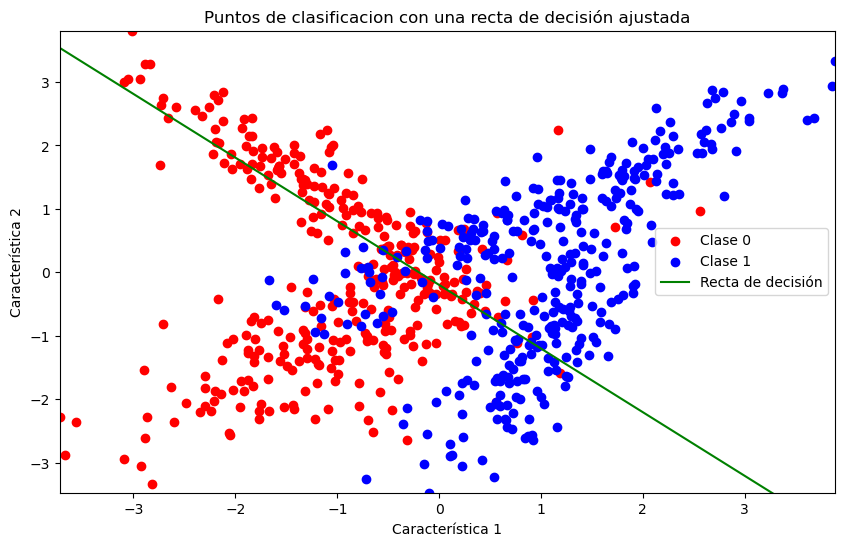

In [6]:
plot_decision_boundary(x_train, y_train, decision_boundary, preact.w[0], preact.w[1], preact.b)

# Enetrenamiento

In [7]:
loss_history = []
lr = 0.1
for _ in range(100):
    sigm(preact(x))
    loss_history.append(np.mean(loss(y)))
    for x_i, y_i in zip(x_train, y_train):
        sigm(preact(x_i)) # forward
        loss.backward(y_i) # backward
        grad_w, grad_b = preact.grad
        preact.w -= lr * grad_w
        preact.b -= lr * grad_b    

# Error durante las epocas

In [8]:
for i, loss in enumerate(loss_history[:10]):
    print("epoca:",i ,"\terror:", loss)

epoca: 0 	error: 0.5708787572638342
epoca: 1 	error: 0.33864841036179044
epoca: 2 	error: 0.33906865183058077
epoca: 3 	error: 0.3390795370670147
epoca: 4 	error: 0.3390798161513718
epoca: 5 	error: 0.33907982330308345
epoca: 6 	error: 0.3390798234863428
epoca: 7 	error: 0.3390798234910388
epoca: 8 	error: 0.33907982349115906
epoca: 9 	error: 0.33907982349116206


# Recta de decision despues del entrenamiento

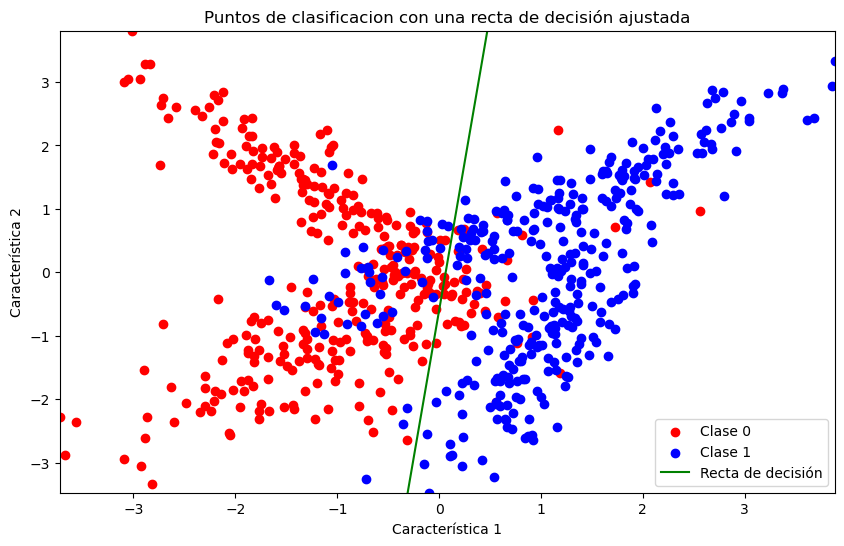

In [9]:
plot_decision_boundary(x_train, y_train, decision_boundary, preact.w[0], preact.w[1], preact.b)

# Recta sobre datos de evaluacion

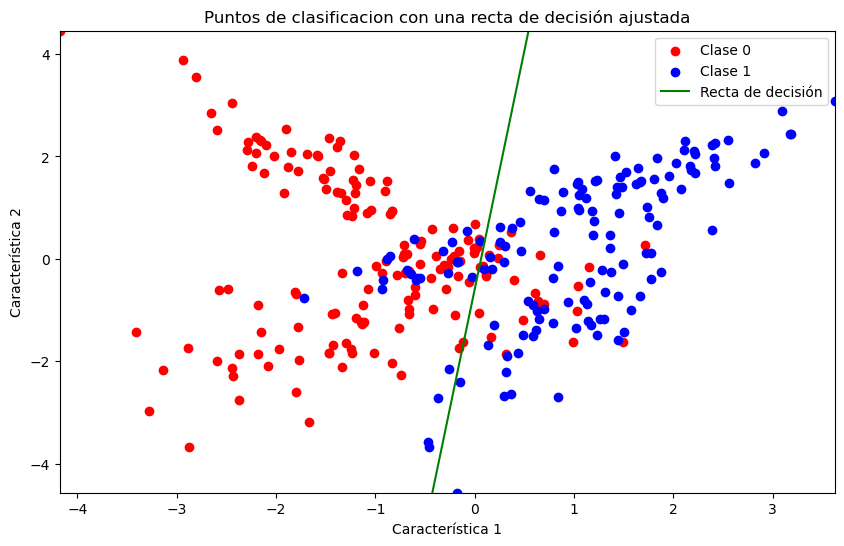

In [10]:
plot_decision_boundary(x_eval, y_eval, decision_boundary, preact.w[0], preact.w[1], preact.b)

In [11]:
from sklearn.metrics import classification_report

y_prob = sigm(preact(x_eval))
y_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_eval, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       160
           1       0.83      0.83      0.83       140

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300

